## **Bayesian Neural Network -- TensorFlow Probability**

The dataset used for prediction comes from a unknown distribution superimposed by additive noise, and for such a particular collection of points different models (i.e. different parameter combinations) might be reasonable. With **Bayesian Neural Networks** we will try to measure the uncertainty about the parameters and predictions being made.

There are several enumerated sources of uncertainty in model prediction of physical phenomena, the primary ones being: 

1) Model form error, 

2) Aleatoric uncertainty of model parameters,

3) Epistemic uncertainty of model parameters, and 

4) Model solution error. These forms of uncertainty can have insidious consequences for modeling if not properly identified and accounted for. (Read more in reference [1]). 

Bayesian statistics provides a framework to deal with the so-called aleoteric and epistemic uncertainty, and with the release of **TensorFlow Probability**, probabilistic modeling has been made a lot easier, as I shall demonstrate with this post

In the figure we can see the idea behind bayesian neural networks in the left side we can see a network that gives us a point estimation and the left hand we have that each node represent a distribution. **With TFP, neural network layers can be distributions**

![alt text](figures/ex.png "Title")

## **Data**

Depending on wether aleotoric, epistimic, or both uncertainties are considered, the code for a Bayesian neural network looks slighty different. To demonstrate the working principle we'll use the **Air Quality dataset.** 

## **Install packages**

In [3]:
#!pip install --upgrade tensorflow-probability
#!pip install --upgrade tensorflow #version 2.1

## **Load packages**

In [20]:
# Load libriaries and functions.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [2]:
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions

In [21]:
# Define helper functions.
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000, behaviour="deprecated", contamination="auto", random_state=0)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x) # Define outlier detector instance.
lin_reg = LinearRegression() # Define linear regression instance.
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x) # Define negative logarithmic likelihood.

## **Load data**

In [25]:
# Load data and keep only first six months due to drift.
data = pd.read_excel("data/AirQualityUCI.xlsx")
data = data[data["Date"] <= "2004-09-10"]

In [26]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


## **Preprocessing**

The data is quite messy and has to be preprocessed first. We will follow the steps:
1) Select columns and remove rows with missing values.

2) Scale data to zero mean and unit variance.

3) Remove outliers: outliers are detected and removed using an **Isolation Forest**.

In [61]:
# 1. Select columns and remove rows with missing values.
columns = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", 
           "T", "AH", "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
data = data[columns].dropna(axis=0)

# 2. Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(data)

# 3. Remove outliers.
is_inlier = detector.fit_predict(X_t)
X_t = X_t[(is_inlier > 0),:]
# Restore frame.
dataset = pd.DataFrame(X_t, columns=columns)
# Select labels for inputs and outputs.
inputs = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH"]
#outputs = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
outputs = ["CO(GT)"]

## **Data Handling**

TensorFlow offers a dataset class to construct training and test sets. We shall use 70% of the data as training set. The sets are shuffled and repeating batches are constructed.


In [62]:
# Define some hyperparameters.
n_epochs = 50
n_samples = dataset.shape[0]
batch_size = np.floor(n_samples/10)
buffer_size = n_samples

# Define training and test data sizes.
n_train = int(0.7*dataset.shape[0])

# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, \
                                           dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1).repeat(n_epochs)

In [63]:
dataset[outputs].values

array([[0.53993919],
       [0.53277221],
       [0.5351612 ],
       ...,
       [0.52560524],
       [0.52799423],
       [0.52918872]])

## **Modelling**

### **Aleotoric Uncertainty**

To account for aleotoric uncertainty, dense layers are combined with probabilistic layers. In particular, the first hidden layer shall consist of ten nodes, the second one needs four nodes for the means plus ten nodes for the variances and covariances of the four-dimensional (there are four outputs) multivariate Gaussian posterior probability distribution in the final layer. This is best achieved using the params_size method of the last layer (MultivariateNormalTriL), which is the declaration of the posterior probability distribution structure, in this case a multivariate normal distribution in which only one half of the covariance matrix is estimated (due to symmetry). The total number of parameters in the model is 224 — estimated by variational methods. The deterministic version of this neural network consists of an input layer, ten latent variables (hidden nodes), and an output layer (114 parameters).


In [ ]:
# Define model instance.
model = tfk.Sequential([
tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
tfk.layers.Dense(10, activation="relu", name="dense_1"),
tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
len(outputs)), activation=None, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(len(outputs), name="output")
], name="model")

# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)

# Run training session.
model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=False)

# Describe model.
model.summary()

## **Plot evaluation**

In [ ]:
# Plot the training session.
fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
plt.xlim(0, np.round(len(model.history.epoch)+4,-1))
plt.ylim(-1, 5)
plt.xlabel("epoch")
plt.ylabel("negative logarithmic likelihood")
plt.plot(list(map(lambda x: x + 1, model.history.epoch)), model.history.history["loss"], label="training", color=plt.cm.viridis(0.3))
plt.plot(list(map(lambda x: x + 1, model.history.epoch)), model.history.history["val_loss"], label="validation", color=plt.cm.viridis(0.6))
plt.legend(frameon=False, loc=0)
plt.savefig('figures/metrics_probabilistic_aleotoric',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

## **Aleotoric and Epistemic Uncertainty**

To account for aleotoric and epistemic uncertainty, only the dense layers have to be exchanged with Flipout layers. Such a model has 424 parameters, since every weight is parametrized by a mean and a standard deviation, hence doubling the amount of parameter weights.

`tfp.layers.DenseFlipout(10, activation="relu", name="dense_1")`

## **Prediction**

In [16]:
# Predict.
samples = 500
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true, Y_true, Y_pred = np.empty(shape=(samples, len(inputs))), 
np.empty(shape=(samples, len(outputs))), 
np.empty(shape=(samples, len(outputs), iterations))

for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true[i,:] = features
    Y_true[i,:] = labels.numpy()
    for k in range(iterations):
        Y_pred[i,:,k] = model.predict(features)
        
# Calculate mean and standard deviation.
Y_pred_m = np.mean(Y_pred, axis=-1)
Y_pred_s = np.std(Y_pred, axis=-1)

In [52]:
Y_true

array([[ 0.51843826,  0.00464621, -0.11197912,  0.14035783],
       [ 0.52679973,  0.12831513, -1.72094769, -1.90714772],
       [ 0.52082725,  0.05754521, -0.01928134,  0.24598311],
       ...,
       [-1.88010963,  0.21264498, -1.72094769, -1.90714772],
       [ 0.51007679,  0.17173439, -0.01266007,  0.47348373],
       [ 0.51485477, -0.00737992, -1.72094769, -1.90714772]])

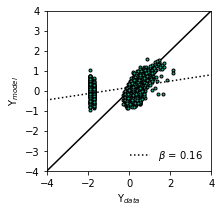

In [22]:
# Determine slope.
slope = lin_reg.fit(Y_true.flatten().reshape(-1, 1), 
                    Y_pred_m.flatten().reshape(-1, 1))

# Perform predictions.
Y_syn = np.linspace(-10, 10, 10)
Y_syn_p = slope.predict(Y_syn.reshape(-1, 1))

# Plot predictions vs. true values.
fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
ax = fig.add_subplot(111)
ax.set_xlabel(r"Y$_{data}$")
ax.set_ylabel(r"Y$_{model}$")
ax.set_xlim(-4.0, 4.0)
ax.set_ylim(-4.0, 4.0)
ax.plot(Y_syn, Y_syn_p, ":", color="k", label=r"$\beta$ = "+str(np.round(slope.coef_[0][0],2)))
ax.plot([-10,10], [-10,10], "-", color="k")
ax.plot(Y_true.flatten(), Y_pred_m.flatten(), color=plt.cm.viridis(0.6), marker=".", alpha=1.0, mec='k', linestyle="")
plt.legend(frameon=False, loc=4, ncol=1)
plt.savefig('figures/congruency_probabilistic_aleotoric',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [60]:
time = ["data.Time"]
time_dt = data["Time"].values
time_dt

array([datetime.time(18, 0), datetime.time(19, 0), datetime.time(20, 0),
       ..., datetime.time(21, 0), datetime.time(22, 0),
       datetime.time(23, 0)], dtype=object)

ValueError: x and y must have same first dimension, but have shapes (4422,) and (2000,)

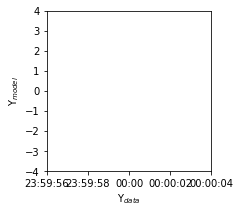

In [40]:
# Plot predictions vs. true values.
fig = plt.figure(figsize=(2.95,2.95))
fig.tight_layout()
ax = fig.add_subplot(111)
ax.set_xlabel(r"Y$_{data}$")
ax.set_ylabel(r"Y$_{model}$")
ax.set_xlim(-4.0, 4.0)
ax.set_ylim(-4.0, 4.0)
ax.plot(data.Time, Y_true.flatten(), color=plt.cm.viridis(0.6), marker=".", alpha=1.0, mec='k', linestyle="")
plt.legend(frameon=False, loc=4, ncol=1)
plt.savefig('figures/congruency_probabilistic_aleotoric',dpi=900,transparent=True,orientation='landscape',bbox_inches='tight')
plt.show()

In [47]:
plt.figure(figsize=(7, 5))
plt.scatter(data.Time.to_numpy(), Y_true)
plt.title("Bayesian Line With Error Bars") 


ValueError: x and y must be the same size

ValueError: microsecond must be in 0..999999

<Figure size 504x360 with 1 Axes>

## **References**

[1]. Epistemic and Aleatoric Uncertainty in Modeling [[Here]](https://asmedigitalcollection.asme.org/IDETC-CIE/proceedings-abstract/IDETC-CIE2013/55997/V008T13A019/256671)